# Preliminary exploratory data analysis:

In [108]:
library(tidyverse)
library(tidymodels)

### Demonstrate that the dataset can be read from the web into R 

In [104]:
spotify_data <- read_csv("https://raw.githubusercontent.com/martin0wong/dsci100_project/main/data/spotify-2023.csv")
spotify_data

Rows: 953 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): track_name, artist(s)_name, streams, key, mode
dbl (17): artist_count, released_year, released_month, released_day, in_spot...
num  (2): in_deezer_playlists, in_shazam_charts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,⋯,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,⋯,125,B,Major,80,89,83,31,0,8,4
LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,⋯,92,C#,Major,71,61,74,7,0,10,4
vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,⋯,138,F,Major,51,32,53,17,0,31,6
Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,⋯,170,A,Major,55,58,72,11,0,11,15
WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,⋯,144,A,Minor,65,23,80,14,63,11,6
Sprinter,"Dave, Central Cee",2,2023,6,1,2186,91,183706234,67,⋯,141,C#,Major,92,66,58,19,0,8,24
Ella Baila Sola,"Eslabon Armado, Peso Pluma",2,2023,3,16,3090,50,725980112,34,⋯,148,F,Minor,67,83,76,48,0,8,3
Columbia,Quevedo,1,2023,7,7,714,43,58149378,25,⋯,100,F,Major,67,26,71,37,0,11,4
fukumean,Gunna,1,2023,5,15,1096,83,95217315,60,⋯,130,C#,Minor,85,22,62,12,0,28,9


### Cleaning and wrangling data into a tidy format.

In [126]:
spotify_data_cleaned <- spotify_data |>
                        mutate(across(streams:bpm, as.numeric))
colnames(spotify_data_cleaned) <- c("track_name", "artist(s)_name", "artist_count", "released_year", "released_month", "released_day", 
                                    "in_spotify_playlists", "in_spotify_charts", "streams", "in_apple_playlists", "in_apple_charts", 
                                    "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts", "bpm", "key", "mode", 
                                    "danceability_percent", "valence_percent", "energy_percent", 
                                    "acousticness_percent", "instrumentalness_percent", "liveness_percent", "speechiness_percent")

spotify_data_final <- select(spotify_data_cleaned, streams, bpm, in_apple_charts, danceability_percent, valence_percent)
spotify_data_final

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(streams:bpm, as.numeric)`.
Caused by warning:
! NAs introduced by coercion”


streams,bpm,in_apple_charts,danceability_percent,valence_percent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
141381703,125,263,80,89
133716286,92,126,71,61
140003974,138,207,51,32
800840817,170,207,55,58
303236322,144,133,65,23
183706234,141,213,92,66
725980112,148,222,67,83
58149378,100,89,67,26
95217315,130,210,85,22


### Using only training data, summarize the data in at least one table (this is exploratory data analysis).

In [127]:
spotify_split <- initial_split(spotify_data_final, prop = 0.75, strata = streams)
spotify_train <- training(spotify_split)
spotify_test <- testing(spotify_split)

spotify_train

streams,bpm,in_apple_charts,danceability_percent,valence_percent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
141381703,125,263,80,89
133716286,92,126,71,61
140003974,138,207,51,32
58149378,100,89,67,26
30546883,78,227,44,14
78300654,130,149,79,96
61245289,122,109,81,74
22581161,126,135,74,35
123122413,120,33,81,63


### Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis).

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


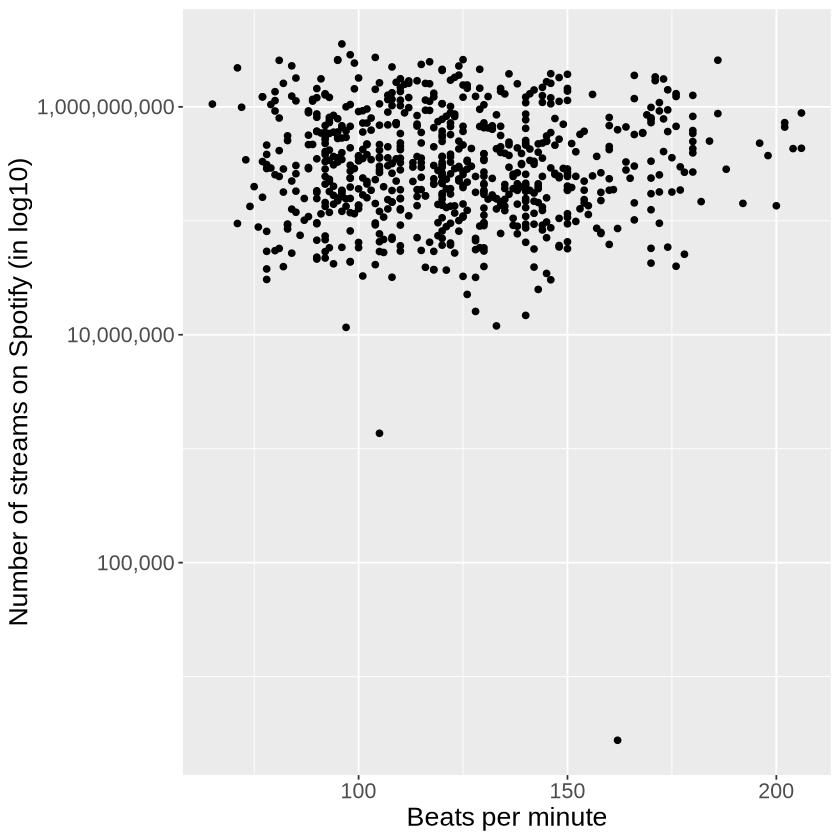

In [120]:
stream_bpm <- ggplot(spotify_train, aes(x = bpm, y = streams)) +
                geom_point() +
                labs(x = "Beats per minute", y = "Number of streams on Spotify (in log10)") +
                scale_y_log10(labels = label_comma()) +
                theme(text = element_text(size = 16))
stream_bpm

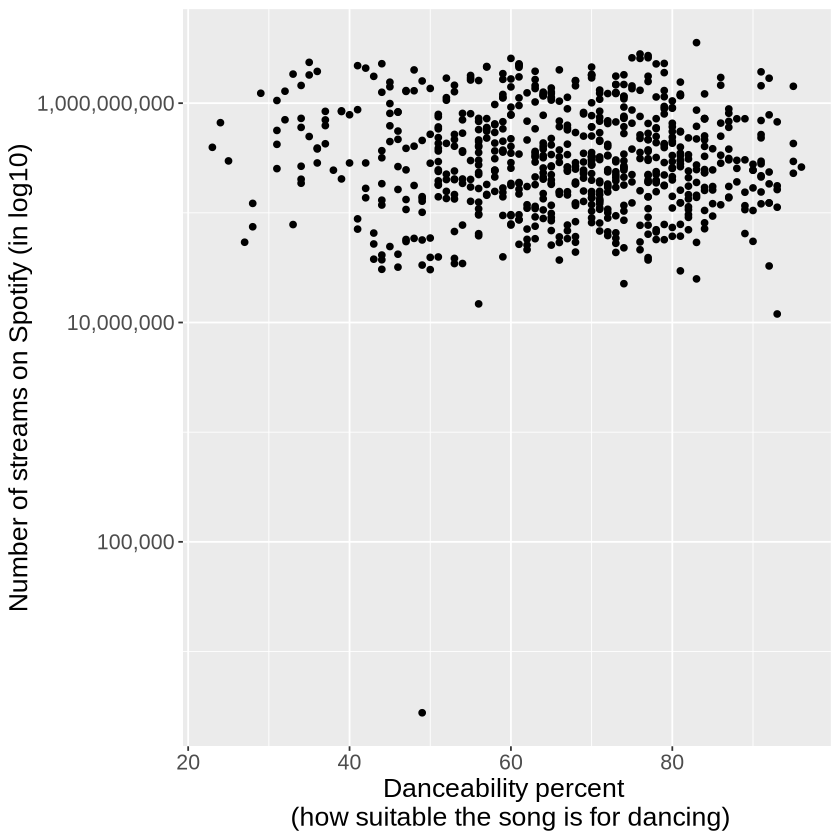

In [128]:
stream_dance <- ggplot(spotify_train, aes(x = danceability_percent, y = streams)) +
                geom_point() +
                labs(x = "Danceability percent \n (how suitable the song is for dancing)", y = "Number of streams on Spotify (in log10)") +
                scale_y_log10(labels = label_comma()) +
                theme(text = element_text(size = 16))
stream_dance